<a href="https://colab.research.google.com/github/Saurx9611/Pnuemonia/blob/main/Pnuemonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kagglehub


In [ ]:
import kagglehub
import os

In [ ]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.


In [ ]:
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: /kaggle/input/chest-xray-pneumonia


In [ ]:
def find_data_paths(root_path):
    for root, dirs, files in os.walk(root_path):
        if 'train' in dirs and 'test' in dirs:
            return root
    return None

data_root = find_data_paths(path)

if data_root:
    train_dir = os.path.join(data_root, 'train')
    test_dir = os.path.join(data_root, 'test')
    val_dir = os.path.join(data_root, 'val')
    print(f"Success!{train_dir}")
else:
    print("Error")

Success! Training data found at: /kaggle/input/chest-xray-pneumonia/chest_xray/train


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values
    rotation_range=20,     # Rotate image slightly
    zoom_range=0.2,        # Zoom in/out
    shear_range=0.2,       # Slant the image
    horizontal_flip=True,  # Flip left/right
    fill_mode='nearest'
)

# 2. Only Rescaling for Test/Validation
test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Create Data Generators
batch_size = 32
img_height, img_width = 224, 224  # Size required by VGG16

# print("Loading Data")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Loading Data...
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

# 1. Load Base Model (VGG16)
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 2. Freeze Base Layers
base_model.trainable = False

# 3. Add Custom Layers
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') # Binary output: 0 (Normal) or 1 (Pneumonia)
])

# 4. Compile Model
# We add 'Recall' to metrics as requested in your project image
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4), # Low learning rate for fine-tuning
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 781ms/step - accuracy: 0.8655 - loss: 0.3212 - recall: 0.9290 - val_accuracy: 0.8125 - val_loss: 0.3801 - val_recall: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 630ms/step - accuracy: 0.9429 - loss: 0.1523 - recall: 0.9598 - val_accuracy: 0.7500 - val_loss: 0.3372 - val_recall: 0.8750
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 629ms/step - accuracy: 0.9462 - loss: 0.1343 - recall: 0.9611 - val_accuracy: 0.6875 - val_loss: 0.6211 - val_recall: 1.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 639ms/step - accuracy: 0.9498 - loss: 0.1370 - recall: 0.9663 - val_accuracy: 0.6875 - val_loss: 0.5493 - val_recall: 1.0000
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 638ms/step - accuracy: 0.9522 - loss: 0.1258 - recall: 0.9688 - val_accuracy: 0.7500 - val_loss: 0.3482 - val_recall: 0.8750
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 631ms/step - accuracy: 0.9574 - loss: 0.1069 - recall: 0.9689 - val_accuracy: 0.9375 - val_loss: 0.2470 -

Generating predictions...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 380ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.74      0.85       234
   Pneumonia       0.87      0.99      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



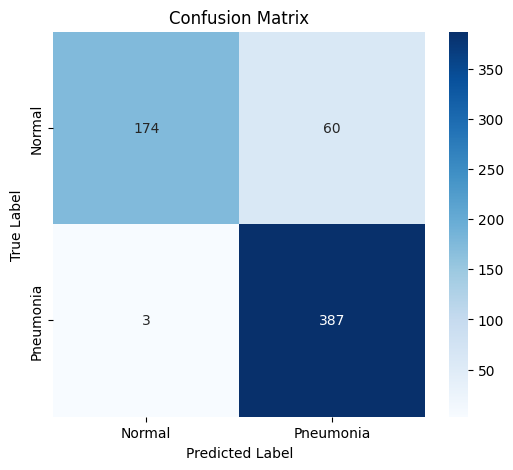

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Get Predictions
# print("Generating predictions")
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = test_generator.classes

# 2. Classification Report
# Pay attention to the "Recall" column for class 1 (Pneumonia)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# 3. Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()